#### Import Dependencies

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [ ]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
from ipywidgets import interact, Checkbox, VBox, HBox

In [ ]:
pd.options.mode.chained_assignment = None

#### Get Annealer TTE into a df column

In [ ]:
def get_annealer_df(results_basepath, report_filename):
    seed = report_filename.split('_')[-1].split('.')[0]
    dwave_annealer_solver = bool(int(report_filename.split('_')[-2][0]))
    gurobi_qubo_solver = bool(int(report_filename.split('_')[-2][1]))

    report_file_obj = open(os.path.join(results_basepath, report_filename),'r')
    table_contents = [line.replace('\n','').split('__') for line in report_file_obj.readlines()]

    annealer_solver_name = 'D-Wave Advantage'
    gurobi_qubo_solver_name = 'Gurobi QUBO (Classical)'

    base_cols = ['No. of Pixels', 'Height', 'Width']
    sub_cols = ['','','']
    if dwave_annealer_solver:
        base_cols = base_cols+[annealer_solver_name]*5
        sub_cols=sub_cols+['Result (Most)', 'Value (Most)','Result (Lowest)', 'Value (Lowest)', 'TTE']
    if gurobi_qubo_solver:
        base_cols = base_cols+[gurobi_qubo_solver_name]*3
        sub_cols=sub_cols+['Result', 'Value', 'TTE']

    column_arrays = [base_cols, sub_cols]

    dwave_annealer_solution_lowest_list = []
    dwave_annealer_solution_most_list = []
    dwave_annealer_value_lowest_list = []
    dwave_annealer_value_most_list = []
    dwave_annealer_occurrences_most_list = []

    df = pd.DataFrame(table_contents, columns=pd.MultiIndex.from_arrays(column_arrays))
    for height in df['Height']:
        sample_set_df = pd.read_csv(os.path.join(results_basepath, f'{seed}',f'{height}_{height}.csv'))
        sample_set_df['energy'] = sample_set_df['energy'].astype(float)
        sample_set_df['num_occurrences'] = sample_set_df['num_occurrences'].astype(int)
        dwave_annealer_solution_lowest_list.append(''.join(sample_set_df.sort_values(by=['energy'], ascending=[True]).iloc[0][:-3].astype(int).astype(str)))
        dwave_annealer_solution_most_list.append(''.join(sample_set_df.sort_values(by=['num_occurrences', 'energy'], ascending=[False, True]).iloc[0][:-3].astype(int).astype(str)))
        dwave_annealer_value_lowest_list.append(sample_set_df.sort_values(by=['energy'], ascending=[True]).iloc[0][-2:-1][0])
        dwave_annealer_value_most_list.append(sample_set_df.sort_values(by=['num_occurrences', 'energy'], ascending=[False, True]).iloc[0][-2:-1][0])
        dwave_annealer_occurrences_most_list.append(list(sample_set_df.sort_values(by=['num_occurrences', 'energy'], ascending=[False, True]).iloc[0])[-1])

    df_annealer = df[['Height','Width']]
    df_annealer['n'] = df['Height'].astype(int) * df['Width'].astype(int)
    df_annealer['annealer_tte'] = df[('D-Wave Advantage','TTE')].astype(float)
    df_annealer['dwave_annealer_solution_lowest'] = dwave_annealer_solution_lowest_list
    df_annealer['dwave_annealer_solution_most'] = dwave_annealer_solution_most_list
    df_annealer['dwave_annealer_value_lowest'] = dwave_annealer_value_lowest_list
    df_annealer['dwave_annealer_value_most'] = dwave_annealer_value_most_list
    df_annealer['dwave_annealer_occurrences_most'] = dwave_annealer_occurrences_most_list

    return df_annealer

#### Get Gurobi TTE into a df column

In [ ]:
def get_gurobi_df(results_basepath, report_filename):
  dwave_annealer_solver = bool(int(report_filename.split('_')[-2][0]))
  gurobi_qubo_solver = bool(int(report_filename.split('_')[-2][1]))

  report_file_obj = open(os.path.join(results_basepath, report_filename),'r')
  table_contents = [line.replace('\n','').split('__') for line in report_file_obj.readlines()]


  annealer_solver_name = 'D-Wave Advantage'
  gurobi_qubo_solver_name = 'Gurobi QUBO (Classical)'


  base_cols = ['No. of Pixels', 'Height', 'Width']
  sub_cols = ['','','']
  if dwave_annealer_solver:
    base_cols = base_cols+[annealer_solver_name]*5
    sub_cols=sub_cols+['Result (Most)', 'Value (Most)','Result (Lowest)', 'Value (Lowest)', 'TTE']
  if gurobi_qubo_solver:
    base_cols = base_cols+[gurobi_qubo_solver_name]*3
    sub_cols=sub_cols+['Result', 'Value', 'TTE']

  column_arrays = [base_cols, sub_cols]

  df = pd.DataFrame(table_contents, columns=pd.MultiIndex.from_arrays(column_arrays))
  df.head()

  df_gurobi = df[['Height','Width']]
  df_gurobi['n'] = df['Height'].astype(int) * df['Width'].astype(int)
  df_gurobi['gurobi_tte'] = df[('Gurobi QUBO (Classical)','TTE')].astype(float)
  df_gurobi['gurobi_min_cut_value'] = df[('Gurobi QUBO (Classical)','Value')]
  df_gurobi.columns = [col[0] for col in df_gurobi.columns]
  return df_gurobi

#### Get QPU Times into a df column

In [ ]:
def get_qpu_times_df(qputimes_file):
    # Replace with your CSV file containing 'height' and 'width' data
    qputimes_df = pd.read_csv(qputimes_file)
    return qputimes_df

#### Merge Gurobi tte, annealet tte and qpu times

In [ ]:
def get_merged_df(df_annealer, df_gurobi, qputimes_df):
  times_df = qputimes_df[['Height','Width','qpu_access_time']]
  times_df['Height'] = times_df['Height'].astype(int)
  times_df['Width'] = times_df['Width'].astype(int)
  times_df['n'] = times_df['Height'] * times_df['Width']
  times_df['qpu_access_time'] = times_df['qpu_access_time'].astype(float)

  times_df['annealer_tte'] = df_annealer['annealer_tte'].astype(float)
  times_df['gurobi_tte'] = df_gurobi['gurobi_tte'].astype(float)
  return times_df

#### Create times_{seed} csv file

In [ ]:
results_basepath = 'results'

seed = 111

df_gurobi = get_gurobi_df(results_basepath,f'imgSeg_paper_report_01_{seed}.txt')
df_annealer = get_annealer_df(results_basepath,f'imgSeg_paper_report_10_{seed}.txt')
qputimes_file = os.path.join(results_basepath,f'imgSeg_paper_qputimes_10_{seed}.csv')
qputimes_df = get_qpu_times_df(qputimes_file)

times_df = qputimes_df[['problem_formulation_time', 'connection_time', 'embedding_time', 'response_time', 'sample_fetch_time']]
times_df['qpu_access_time'] = qputimes_df['qpu_access_time']/10**6
times_df['n'] = qputimes_df['Height'].astype(int) * qputimes_df['Width'].astype(int)
times_df['annealer_tte'] = df_annealer['annealer_tte']
times_df['gurobi_tte'] = df_gurobi['gurobi_tte']


times_df.to_csv(os.path.join(results_basepath, f'times_{seed}.csv'), index=False)

In [ ]:
results_basepath = 'results'
seed = 222

times_df = pd.read_csv(os.path.join(results_basepath, f'times_{seed}.csv'))
times_df

#### Annealer execution times Interactive figure

In [ ]:
def plot_interactive_qpu_times(times_df_filename):

    times_df = pd.read_csv(times_df_filename)

    # Create a function to update the plot based on selected checkboxes
    def update_plot(problem_formulation_time, connection_time, embedding_time, qpu_access_time, response_time, sample_fetch_time, selected_sum, annealer_tte, gurobi_tte):
        plt.figure(figsize=(18, 10))

        linewidth = 3.0

        if problem_formulation_time:
            plt.plot(times_df['n'], times_df['problem_formulation_time'], label='Problem Formulation', color='#FFC0CB', linewidth=linewidth)
        if connection_time:
            plt.plot(times_df['n'], times_df['connection_time'], label='Connection', color='#FF8000', linewidth=linewidth)
        if embedding_time:
            plt.plot(times_df['n'], times_df['embedding_time'], label='Embedding', color='#00FFFF', linewidth=linewidth)
        if qpu_access_time:
            plt.plot(times_df['n'], times_df['qpu_access_time'], label='QPU Access', color='#0066CC', linewidth=linewidth)
        if response_time:
            plt.plot(times_df['n'], times_df['response_time'], label='Response', color='#990099', linewidth=linewidth)
        if sample_fetch_time:
            plt.plot(times_df['n'], times_df['sample_fetch_time'], label='Sample Fetch', color='#CCCC00', linewidth=linewidth)
        if selected_sum:
            y = int(problem_formulation_time)*times_df['problem_formulation_time'] \
               +int(connection_time)*times_df['connection_time'] \
               +int(embedding_time)*times_df['embedding_time'] \
               +int(qpu_access_time)*times_df['qpu_access_time'] \
               +int(response_time)*times_df['response_time'] \
               +int(sample_fetch_time)*times_df['sample_fetch_time']
            plt.plot(times_df['n'], y, label='Selected Sum', color='k', linewidth=linewidth)
        if annealer_tte:
            plt.plot(times_df['n'], times_df['annealer_tte'], label='Annealer Total Time', color='#00994D', linewidth=linewidth)
        if gurobi_tte:
            plt.plot(times_df['n'], times_df['gurobi_tte'], label='Gurobi Total Time', color='#FF0000', linewidth=linewidth)

        plt.xlabel('Number of Pixels', fontsize=28)
        plt.ylabel('Time (seconds)', fontsize=28)
        plt.title('Interactive Time Plot')

        # plt.legend()
        leg = plt.legend()

        # get the lines and texts inside legend box
        leg_lines = leg.get_lines()
        leg_texts = leg.get_texts()

        # bulk-set the properties of all lines and texts
        plt.setp(leg_lines, linewidth=1)
        plt.setp(leg_texts, fontsize=22)
        plt.xticks(fontsize= 22)
        plt.yticks(fontsize= 22)
        plt.legend(fontsize=28)
        plt.grid()

        # Set y-axis limits to keep the scale constant
        # plt.ylim([0, 300])  # Change the limits according to the data

        save_file_path = os.path.join("plots","runtimes.png")
        plt.savefig(save_file_path, dpi=300, bbox_inches='tight')
        plt.show()


    # Create interactive checkboxes
    checkbox_problem_formulation_time = Checkbox(value=True, description='problem_formulation_time')
    checkbox_connection_time = Checkbox(value=True, description='connection_time')
    checkbox_embedding_time = Checkbox(value=True, description='embedding_time')
    checkbox_qpu_access_time = Checkbox(value=True, description='qpu_access_time')
    checkbox_response_time = Checkbox(value=True, description='response_time')
    checkbox_sample_fetch_time = Checkbox(value=True, description='sample_fetch_time')
    checkbox_selected_sum = Checkbox(value=False, description='Selected Total time')
    checkbox_annealer_tte = Checkbox(value=True, description='Annealer Total Time to Execute')
    checkbox_gurobi_tte = Checkbox(value=True, description='Gurobi Total Time to Execute')

    # Create HBoxes to hold the checkboxes
    checkboxes_row1 = HBox([checkbox_problem_formulation_time, checkbox_connection_time, checkbox_embedding_time, checkbox_qpu_access_time, checkbox_response_time, checkbox_sample_fetch_time])
    checkboxes_row2 = HBox([checkbox_selected_sum, checkbox_annealer_tte, checkbox_gurobi_tte])

    # Combine the HBoxes into a single VBox for the right side
    checkboxes_right = VBox([checkboxes_row1, checkboxes_row2])


    # Use the interact function to create the interactive plot
    interact(update_plot,
             problem_formulation_time = checkbox_problem_formulation_time,
             connection_time=checkbox_connection_time,
             embedding_time=checkbox_embedding_time,
             qpu_access_time=checkbox_qpu_access_time,
             response_time=checkbox_response_time,
             sample_fetch_time=checkbox_sample_fetch_time,
             selected_sum = checkbox_selected_sum,
             annealer_tte=checkbox_annealer_tte,
             gurobi_tte = checkbox_gurobi_tte
             )

    display(checkboxes_right)

    plt.figure(figsize=(24, 6))
    plt.imshow(plt.imread('test3.png'))
    plt.axis('off')
    plt.show()


interactive(children=(Checkbox(value=True, description='problem_formulation_time'), Checkbox(value=True, descr…

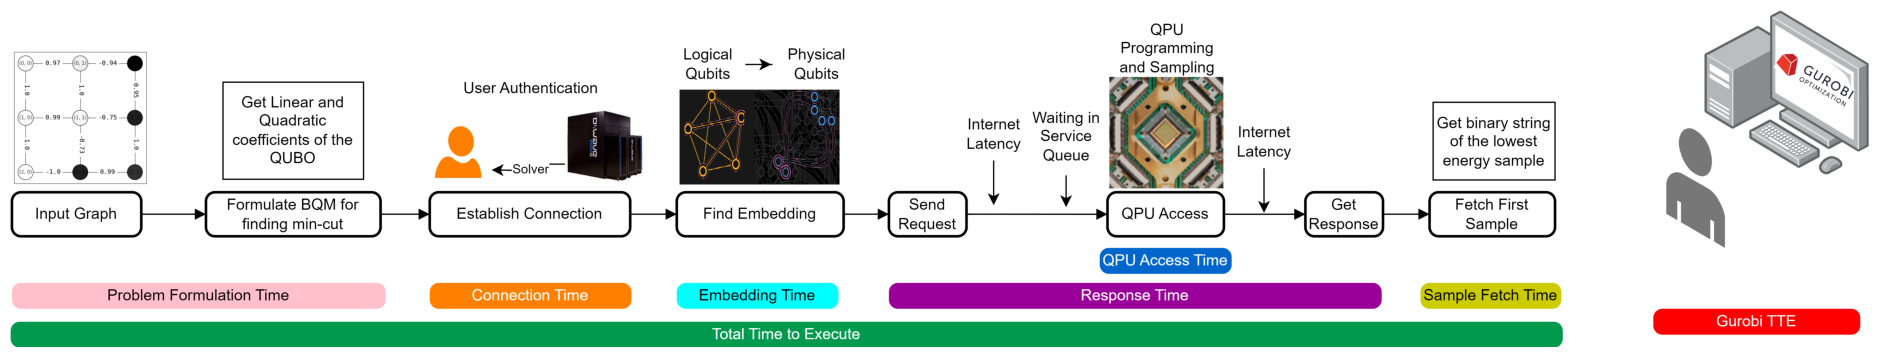

In [ ]:
results_basepath = 'v7\colab'
seed = 222

plot_interactive_qpu_times(os.path.join(results_basepath, f'times_{seed}.csv'))

In [ ]:
def get_and_plot_times(times_df_filename):
    times_df = pd.read_csv(times_df_filename)

    plt.figure(figsize=(18, 10))
    linewidth = 3.0
    annealer_times = times_df['problem_formulation_time'] \
       +times_df['connection_time'] \
       +times_df['embedding_time'] \
       +times_df['qpu_access_time'] \
       +times_df['response_time'] \
       +times_df['sample_fetch_time']
    gurobi_times = times_df['gurobi_tte']
    plt.plot(times_df['n'], annealer_times, label='Annealer', color='#00994D', linewidth=linewidth)
    plt.plot(times_df['n'], gurobi_times, label='Gurobi', color='#FF0000', linewidth=linewidth)
    plt.xlabel('Number of Pixels', fontsize=28)
    plt.ylabel('Time (seconds)', fontsize=28)
    leg = plt.legend()
    leg_lines = leg.get_lines()
    leg_texts = leg.get_texts()
    plt.setp(leg_lines, linewidth=1)
    plt.setp(leg_texts, fontsize=22)
    plt.xticks(fontsize= 22)
    plt.yticks(fontsize= 22)
    plt.legend(fontsize=28)
    plt.grid()
    save_file_path = os.path.join("plots","practical_runtimes.png")
    plt.savefig(save_file_path, dpi=300, bbox_inches='tight')
    plt.show()
    return annealer_times, gurobi_times

In [ ]:
def get_practical_times(times_df_filename):
    times_df = pd.read_csv(times_df_filename)
    annealer_times = times_df['problem_formulation_time'] \
       +times_df['embedding_time'] \
       +times_df['qpu_access_time'] \
       +times_df['sample_fetch_time']
    gurobi_times = times_df['gurobi_tte']
    return annealer_times, gurobi_times, times_df['n']

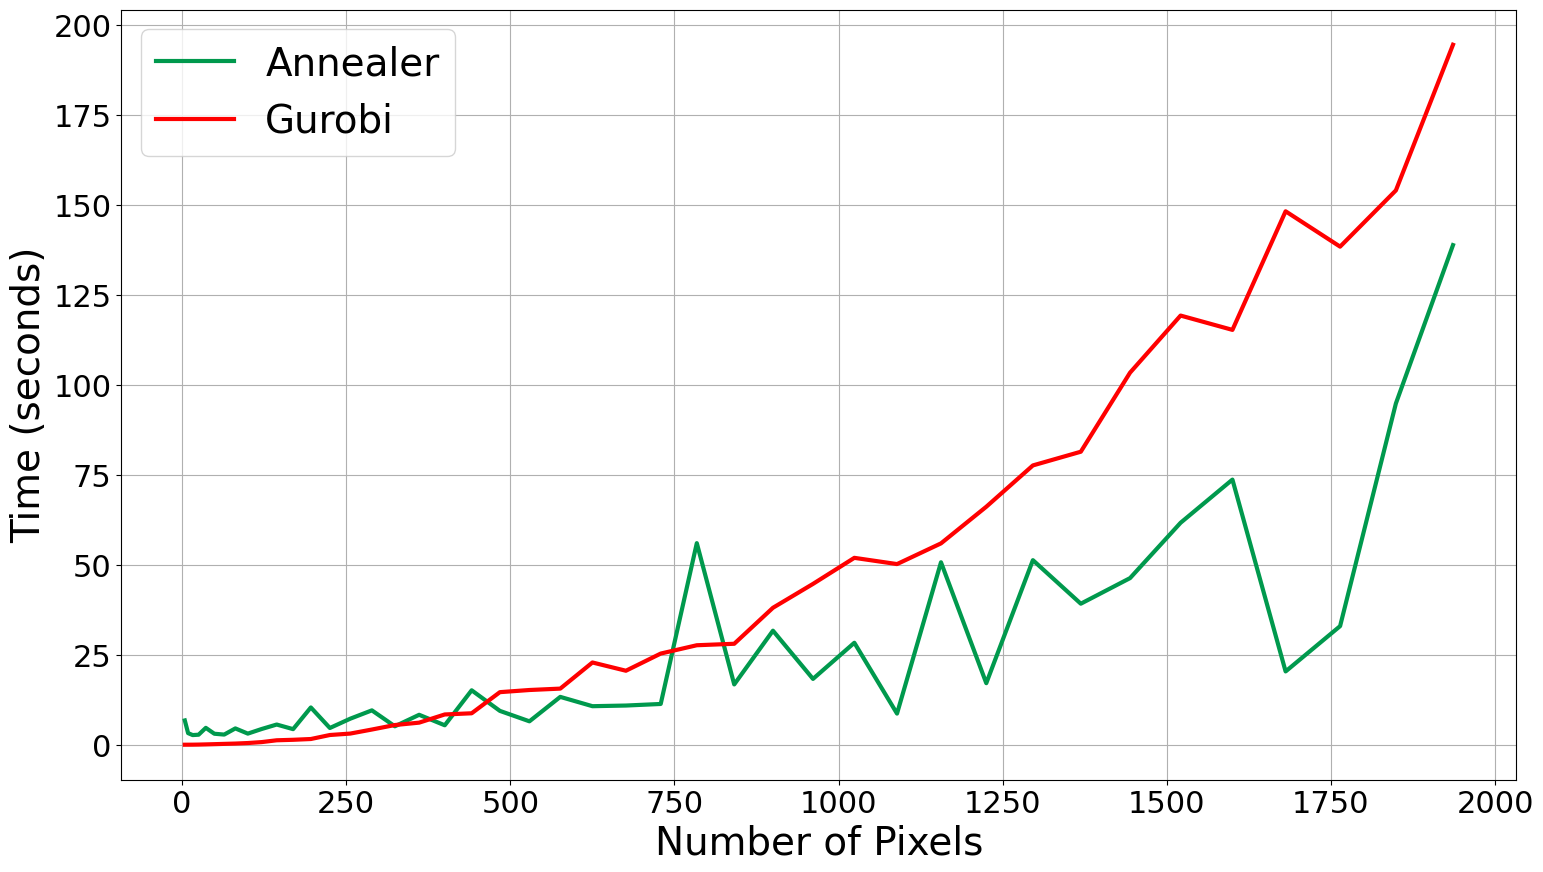

In [ ]:
results_basepath = 'v7\colab'
seed = 222

annealer_times, gurobi_times = get_and_plot_times(os.path.join(results_basepath, f'times_{seed}.csv'))

In [ ]:
def plot_practical_qpu_times(times_df_filename):

    times_df = pd.read_csv(times_df_filename)
    # print(list(zip(np.sqrt(times_df['n']),times_df['annealer_tte'])))

    # Create a function to update the plot based on selected checkboxes
    def update_plot(problem_formulation_time, connection_time, embedding_time, qpu_access_time, response_time, sample_fetch_time, selected_sum, annealer_tte, gurobi_tte):
        plt.figure(figsize=(18, 10))

        linewidth = 3.0

        if selected_sum:
            y = int(problem_formulation_time)*times_df['problem_formulation_time'] \
               +int(connection_time)*times_df['connection_time'] \
               +int(embedding_time)*times_df['embedding_time'] \
               +int(qpu_access_time)*times_df['qpu_access_time'] \
               +int(response_time)*times_df['response_time'] \
               +int(sample_fetch_time)*times_df['sample_fetch_time']
            plt.plot(times_df['n'], y, label='Q-Seg using Annealer', color='#00994D', linewidth=linewidth)
        if gurobi_tte:
            plt.plot(times_df['n'], times_df['gurobi_tte'], label='Q-Seg using Gurobi', color='#FF0000', linewidth=linewidth)

        plt.xlabel('Number of Pixels', fontsize=28)
        plt.ylabel('Time (seconds)', fontsize=28)

        leg = plt.legend()

        # get the lines and texts inside legend box
        leg_lines = leg.get_lines()
        leg_texts = leg.get_texts()

        # bulk-set the properties of all lines and texts
        plt.setp(leg_lines, linewidth=1)
        plt.setp(leg_texts, fontsize=22)
        plt.xticks(fontsize= 22)
        plt.yticks(fontsize= 22)
        plt.legend(fontsize=28)
        plt.grid()

        # Set y-axis limits to keep the scale constant
        # plt.ylim([0, 300])  # Change the limits according to the data

        save_file_path = os.path.join("plots","practical_runtimes.png")
        plt.savefig(save_file_path, dpi=300, bbox_inches='tight')
        plt.show()


    # Create interactive checkboxes
    checkbox_problem_formulation_time = Checkbox(value=True, description='problem_formulation_time')
    checkbox_connection_time = Checkbox(value=True, description='connection_time')
    checkbox_embedding_time = Checkbox(value=True, description='embedding_time')
    checkbox_qpu_access_time = Checkbox(value=True, description='qpu_access_time')
    checkbox_response_time = Checkbox(value=False, description='response_time')
    checkbox_sample_fetch_time = Checkbox(value=True, description='sample_fetch_time')
    checkbox_selected_sum = Checkbox(value=True, description='Q-Seg')
    checkbox_annealer_tte = Checkbox(value=False, description='Annealer Total Time to Execute')
    checkbox_gurobi_tte = Checkbox(value=True, description='Gurobi')

    # Create HBoxes to hold the checkboxes
    checkboxes_row1 = HBox([checkbox_problem_formulation_time, checkbox_connection_time, checkbox_embedding_time, checkbox_qpu_access_time, checkbox_response_time, checkbox_sample_fetch_time])
    checkboxes_row2 = HBox([checkbox_selected_sum, checkbox_annealer_tte, checkbox_gurobi_tte])

    # Combine the HBoxes into a single VBox for the right side
    checkboxes_right = VBox([checkboxes_row1, checkboxes_row2])


    # Use the interact function to create the interactive plot
    interact(update_plot,
             problem_formulation_time = checkbox_problem_formulation_time,
             connection_time=checkbox_connection_time,
             embedding_time=checkbox_embedding_time,
             qpu_access_time=checkbox_qpu_access_time,
             response_time=checkbox_response_time,
             sample_fetch_time=checkbox_sample_fetch_time,
             selected_sum = checkbox_selected_sum,
             annealer_tte=checkbox_annealer_tte,
             gurobi_tte = checkbox_gurobi_tte
             )

    display(checkboxes_right)

    plt.figure(figsize=(24, 6))
    plt.imshow(plt.imread('test3.png'))
    plt.axis('off')
    plt.show()


In [ ]:
results_basepath = 'v7\colab'
seed = 222

plot_practical_qpu_times(os.path.join(results_basepath, f'times_{seed}.csv'))

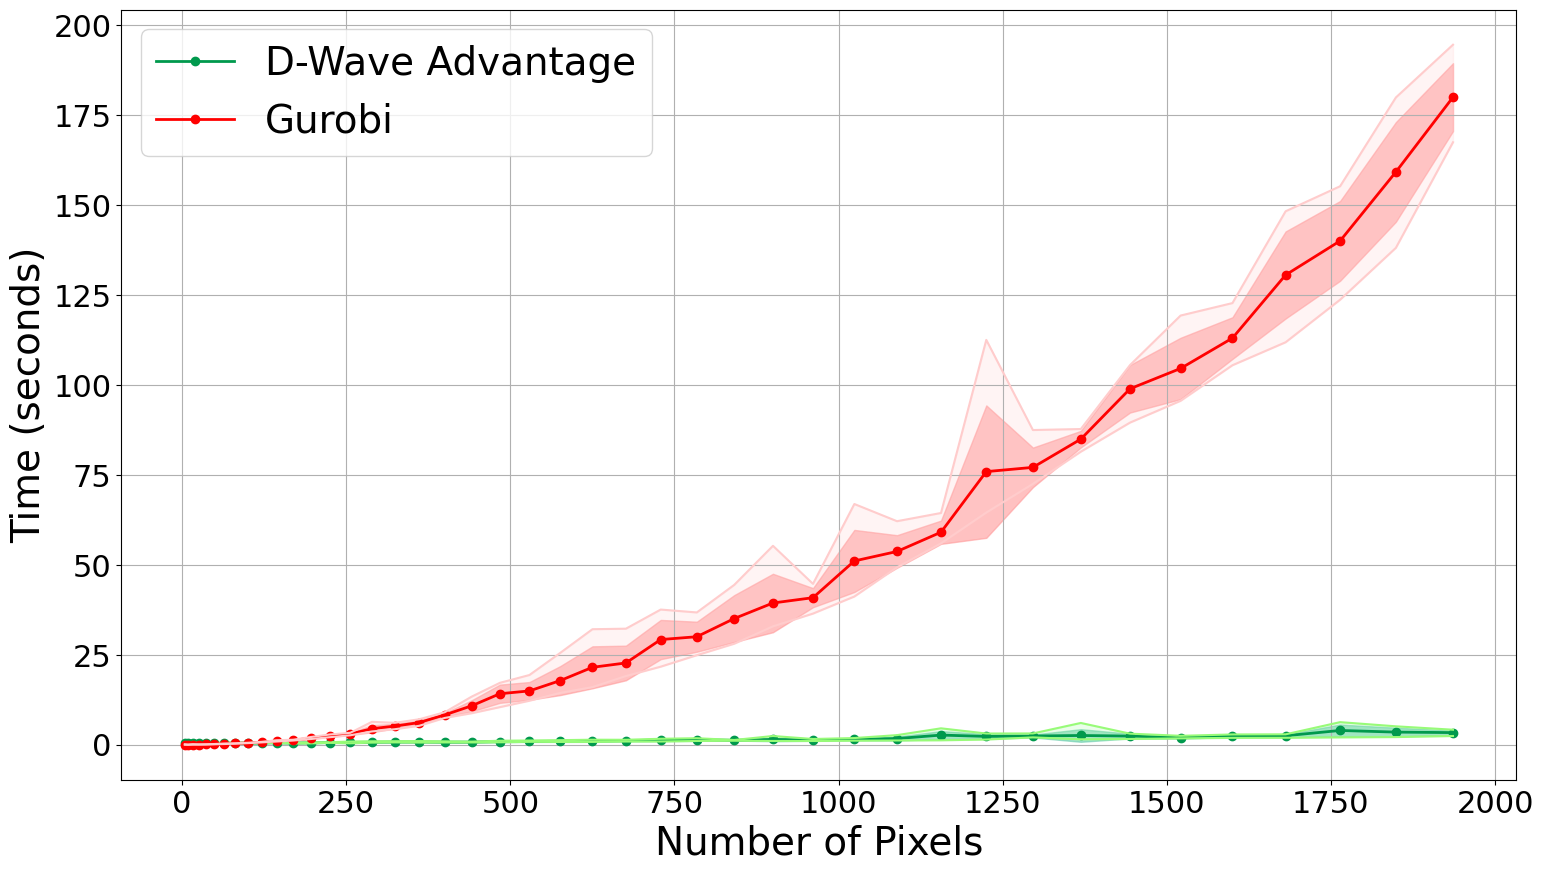

In [ ]:
# Initialize lists to store the results
all_annealer_times = []
all_gurobi_times = []

# Define your seeds
seeds = [111, 222, 333, 444, 555]
results_basepath = 'results'

# Loop through the seeds and call your function
for seed in seeds:
    filename = os.path.join(results_basepath, f'times_{seed}.csv')
    annealer_times, gurobi_times, ns = get_practical_times(filename)
    all_annealer_times.append(annealer_times)
    all_gurobi_times.append(gurobi_times)

# Convert lists to numpy arrays for easier calculations
all_annealer_times = np.array(all_annealer_times)
all_gurobi_times = np.array(all_gurobi_times)

# Calculate statistics
mean_annealer = np.mean(all_annealer_times, axis=0)
min_annealer = np.min(all_annealer_times, axis=0)
max_annealer = np.max(all_annealer_times, axis=0)
std_annealer = np.std(all_annealer_times, axis=0)

upper_annealer = mean_annealer + std_annealer
lower_annealer = mean_annealer - std_annealer


mean_gurobi = np.mean(all_gurobi_times, axis=0)
min_gurobi = np.min(all_gurobi_times, axis=0)
max_gurobi = np.max(all_gurobi_times, axis=0)
std_gurobi = np.std(all_gurobi_times, axis=0)

upper_gurobi = mean_gurobi + std_gurobi
lower_gurobi = mean_gurobi - std_gurobi

plt.figure(figsize=(18, 10))

# Annealer plots
plt.plot(ns, mean_annealer, linestyle='-', marker='o', linewidth=2.0, markeredgewidth=1, color='#00994D', label = 'D-Wave Advantage')
plt.fill_between(ns, lower_annealer, upper_annealer, color='#66CDAA', alpha=0.6) #, label=r"$\mu \pm \sigma$")
plt.fill_between(ns, min_annealer, max_annealer, color='#98FB98', alpha=0.2) #, label="MIN-MAX")
plt.plot(ns, max_annealer, color='#98FB78')
plt.plot(ns, min_annealer, color='#98FB78')

# Gurobi plots
plt.plot(ns, mean_gurobi, linestyle='-', marker='o', linewidth=2.0, markeredgewidth=1, color='#FF0000', label = 'Gurobi')
plt.fill_between(ns, lower_gurobi, upper_gurobi, color='#FF9999', alpha=0.6) #, label=r"$\mu \pm \sigma$")
plt.fill_between(ns, min_gurobi, max_gurobi, color='#FFCCCC', alpha=0.2) #, label="MIN-MAX")
plt.plot(ns, max_gurobi, color='#FFCCCC')
plt.plot(ns, min_gurobi, color='#FFCCCC')


plt.xlabel('Number of Pixels', fontsize=28)
plt.ylabel('Time (seconds)', fontsize=28)
leg = plt.legend()
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
plt.setp(leg_lines, linewidth=1)
plt.setp(leg_texts, fontsize=24)
plt.xticks(fontsize= 22)
plt.yticks(fontsize= 22)
plt.legend(fontsize=28)
plt.grid()
save_file_path = os.path.join("plots","practical_runtimes_3.png")
plt.savefig(save_file_path, dpi=300, bbox_inches='tight')
plt.show()



#### Annealer v/s Gurobi (Quality)

##### Create values_{seed} csv file

In [ ]:
def save_values_df(results_basepath, seed):
  df_gurobi = get_gurobi_df(results_basepath,f'imgSeg_paper_report_01_{seed}.txt')
  gurobi_values = df_gurobi['gurobi_min_cut_value'].astype(float)


  df_annealer = get_annealer_df(results_basepath,f'imgSeg_paper_report_10_{seed}.txt')
  annealer_most_values = df_annealer['dwave_annealer_value_most'].astype(float)
  annealer_occurrences_most = df_annealer['dwave_annealer_occurrences_most'].astype(int)
  annealer_lowest_values = df_annealer['dwave_annealer_value_lowest'].astype(float)

  values_df = df_gurobi[['Height','Width','n']]

  values_df['gurobi_value'] = gurobi_values
  values_df['annealer_lowest_value'] = annealer_lowest_values
  values_df['annealer_most_value'] = annealer_most_values
  values_df['annealer_most_occurrences'] = annealer_occurrences_most


  values_df.to_csv(os.path.join(results_basepath, f'values_{seed}.csv'), index=False)

In [ ]:
results_basepath = 'results'

# seeds = [111,222,333,444,555]
seed = 333


save_values_df(results_basepath, seed)

##### Plot the data in values_{seed} csv file

In [ ]:
results_basepath = 'results'
seed = 333

values_df = pd.read_csv(os.path.join(results_basepath, f'values_{seed}.csv'))
values_df.head()

,Height,Width,n,gurobi_value,annealer_lowest_value,annealer_most_value,annealer_most_occurrences
0,2,2,4,-1.3100,-1.310000,-1.308967,1190
1,3,3,9,-5.6640,-5.663957,-5.662045,638
2,4,4,16,-9.1561,-9.156076,-9.154739,712
3,5,5,25,-14.3609,-14.360876,-14.351763,203
4,6,6,36,-19.0970,-19.096960,-19.073653,123


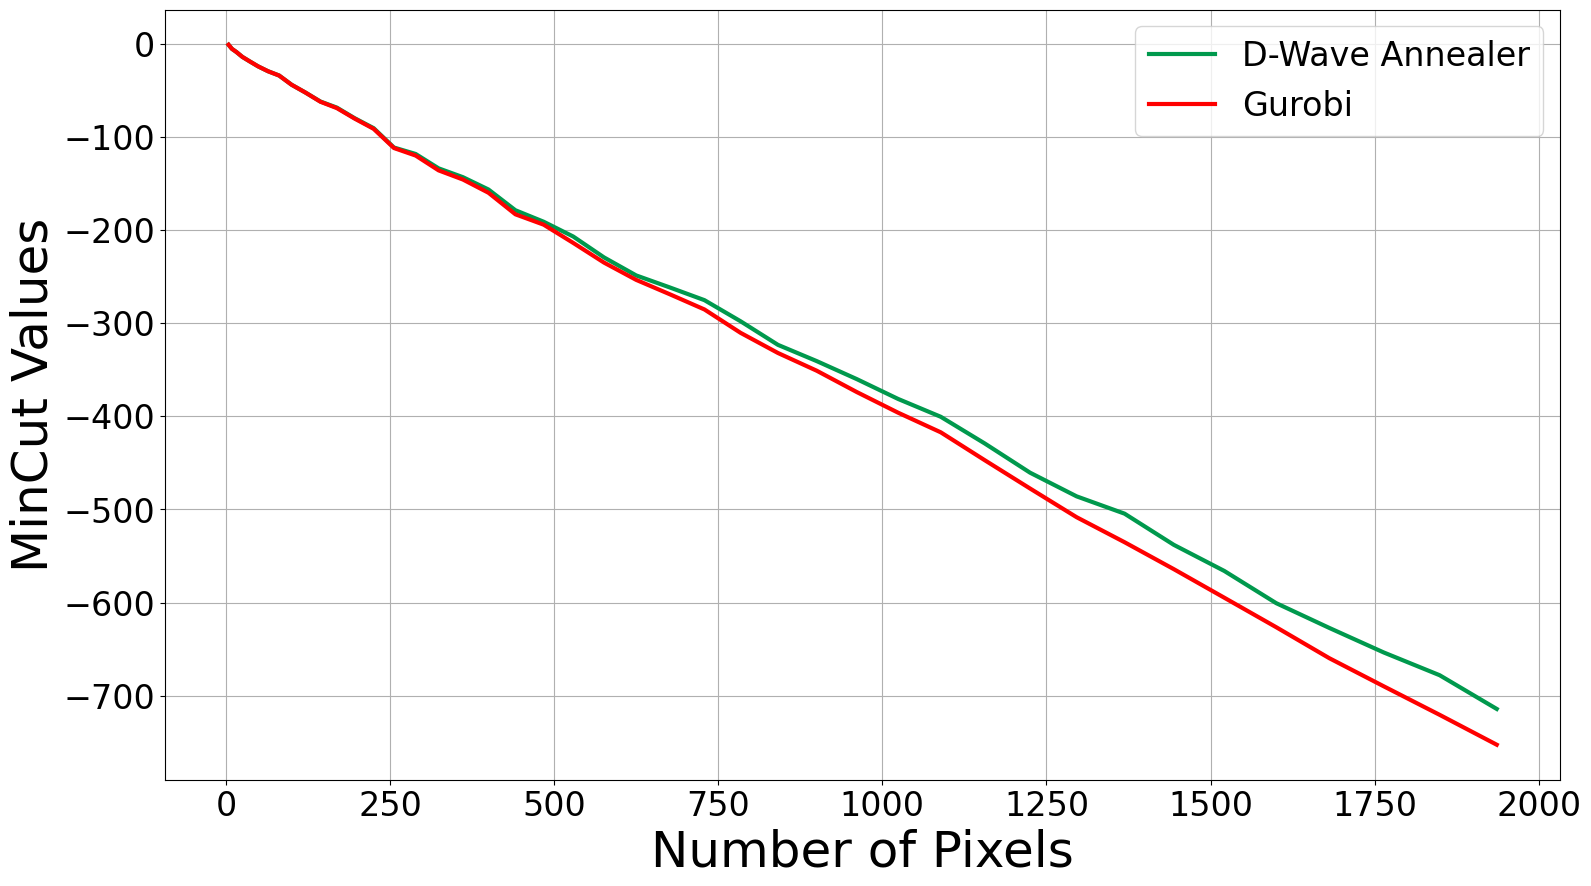

In [ ]:
x = values_df['n'].astype(int)
annealer_values_lowest = values_df['annealer_lowest_value'].astype(float)

gurobi_values = values_df['gurobi_value'].astype(float)

plt.figure(figsize=(18, 10))

linewidth = 3

plt.plot(x, annealer_values_lowest, label='D-Wave Annealer', color='#00994D', linewidth=linewidth)
plt.plot(x, gurobi_values, label='Gurobi', color='#FF0000', linewidth=linewidth)
# plt.ylim([0,1])

plt.xlabel('Number of Pixels', fontsize=36)
plt.ylabel('MinCut Values', fontsize=36)

# plt.title('Interactive Time Plot')
# plt.legend()
leg = plt.legend()
# get the lines and texts inside legend box
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# bulk-set the properties of all lines and texts
plt.setp(leg_lines, linewidth=1)
plt.setp(leg_texts, fontsize=36)
plt.xticks(fontsize= 24)
plt.yticks(fontsize= 24)
plt.legend(fontsize=24)
plt.grid()
# Set y-axis limits to keep the scale constant
# plt.ylim([0, 300])  # Change the limits according to your data
save_file_path = os.path.join("plots","annealer_vs_gurobi_mincut_values.png")
plt.savefig(save_file_path, dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
results_basepath = 'results'
seed = 333

values_df = pd.read_csv(os.path.join(results_basepath, f'values_{seed}.csv'))
values_df.head()

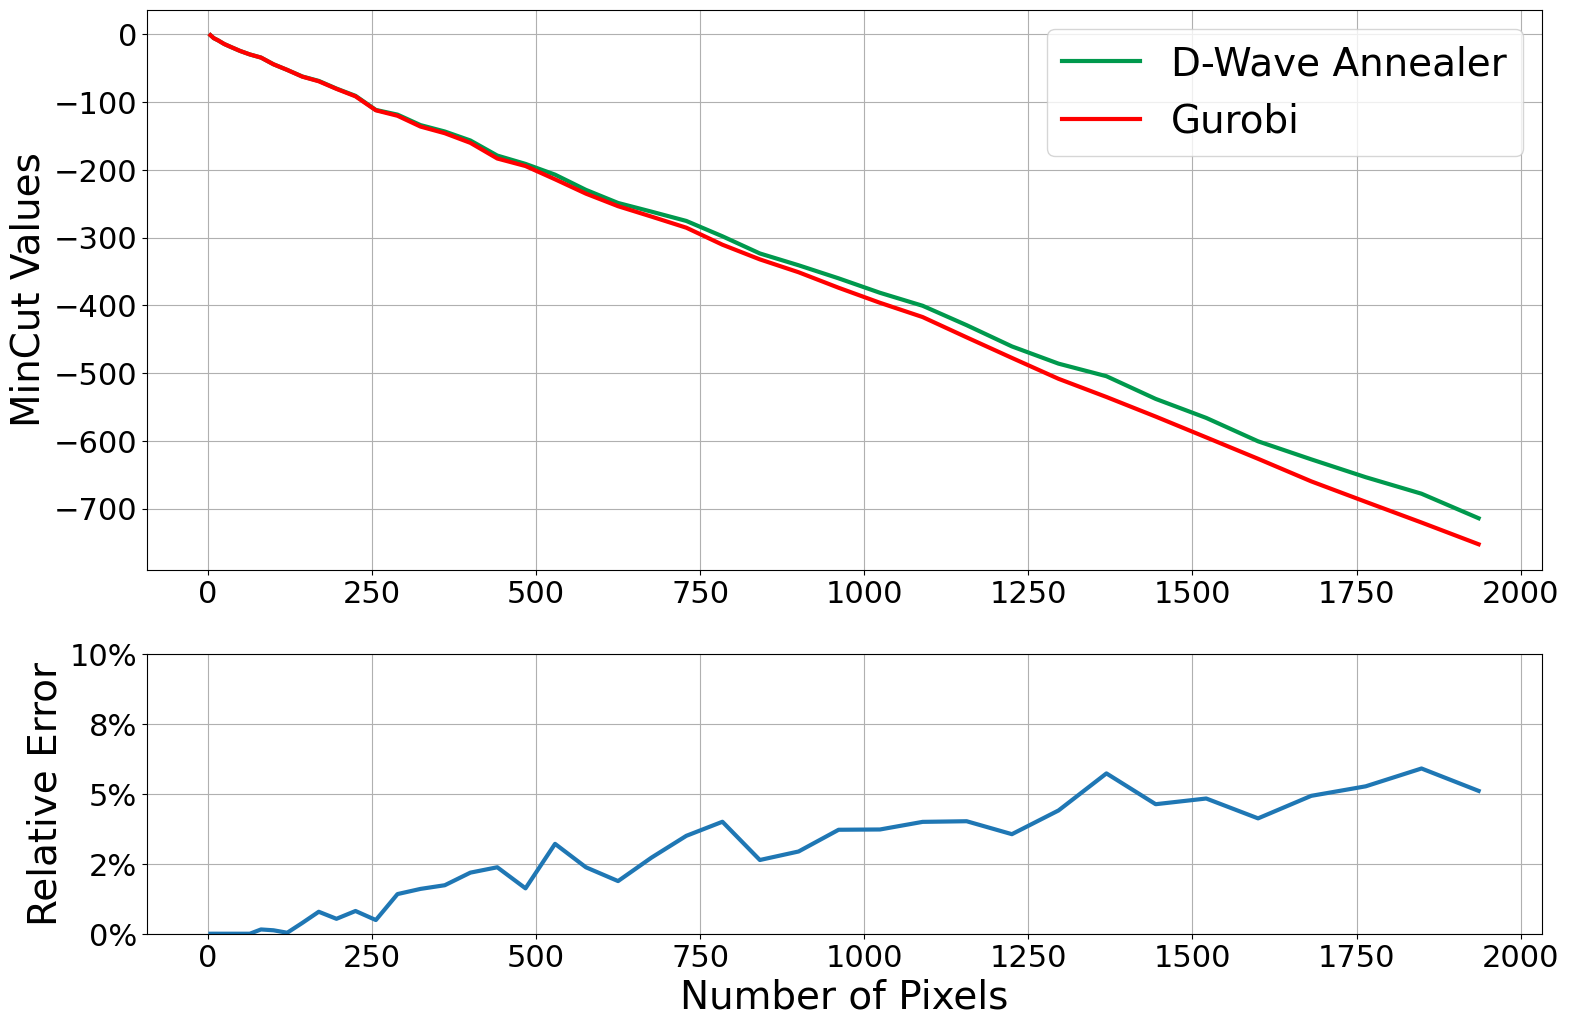

In [ ]:


# Your existing data preparation code
x = values_df['n'].astype(int)
annealer_values_lowest = values_df['annealer_lowest_value'].astype(float)
gurobi_values = values_df['gurobi_value'].astype(float)
annealer_values = -annealer_values_lowest
gurobi_values_neg = -values_df['gurobi_value'].astype(float)
annealer_vs_gurobi_quality = ((gurobi_values_neg - annealer_values) / gurobi_values_neg)

# Create a figure and two subplots with shared x-axis and adjusted heights
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12), sharex=True, gridspec_kw={'height_ratios': [1, 0.5]})

# Plotting on the first subplot
linewidth = 3
ax1.plot(x, annealer_values_lowest, label='D-Wave Advantage', color='#00994D', linewidth=linewidth)
ax1.plot(x, gurobi_values, label='Gurobi', color='#FF0000', linewidth=linewidth)
ax1.set_ylabel('MinCut Values', fontsize=28)
ax1.legend(fontsize=28)
ax1.tick_params(axis='both', which='major', labelsize=22)
ax1.grid()
ax1.xaxis.set_tick_params(which='both', labelbottom=True)  # Display x-axis ticks

# Plotting on the second subplot
quality_line, = ax2.plot(x, annealer_vs_gurobi_quality, label='Quality', linewidth=linewidth)
ax2.set_ylim(0, 0.1)  # Set y-axis range from 0% to 20%
ax2.set_yticks(np.linspace(0, 0.1, 5))  # Adjust the y-ticks accordingly
ax2.set_yticklabels([f'{y*100:.0f}%' for y in np.linspace(0, 0.1, 5)])
ax2.set_ylabel('Relative Error', fontsize=28)
ax2.tick_params(axis='y', labelsize=22)
ax2.tick_params(axis='x', labelsize=22)
ax2.grid()

# Set common x-label
plt.xlabel('Number of Pixels', fontsize=28)

# Save the figure
save_file_path = os.path.join("plots", "annealer_vs_gurobi_mincut_values.png")
plt.savefig(save_file_path, dpi=300, bbox_inches='tight')
plt.show()


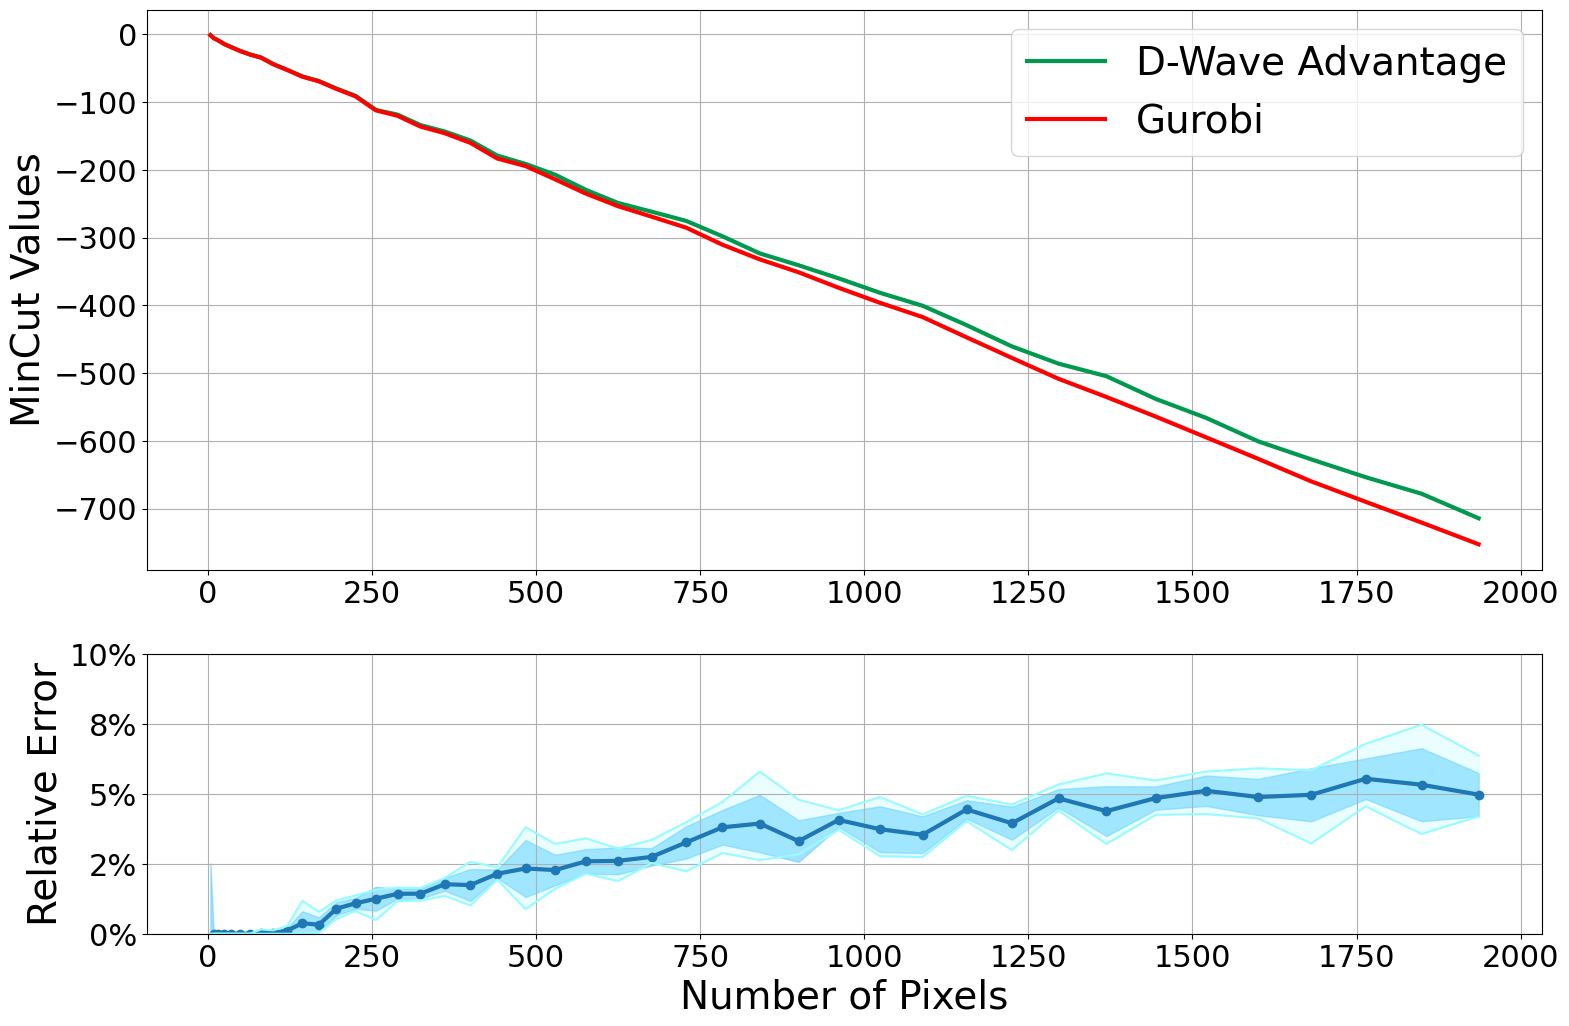

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store results
all_quality_values = []

# Define your seeds
seeds = [111, 222, 444, 555, 333]
results_basepath = 'results'

# Loop through the seeds and collect data
for seed in seeds:
    filename = os.path.join(results_basepath, f'values_{seed}.csv')
    values_df = pd.read_csv(filename)

    x = values_df['n'].astype(int)
    annealer_values_lowest = values_df['annealer_lowest_value'].astype(float)
    gurobi_values = values_df['gurobi_value'].astype(float)
    annealer_values = -annealer_values_lowest
    gurobi_values_neg = -values_df['gurobi_value'].astype(float)
    annealer_vs_gurobi_quality = ((gurobi_values_neg - annealer_values) / gurobi_values_neg)

    all_quality_values.append(annealer_vs_gurobi_quality)


# Calculate mean across seeds
mean_quality = np.mean(all_quality_values, axis=0)
min_quality = np.min(all_quality_values, axis=0)
max_quality = np.max(all_quality_values, axis=0)
std_quality = np.std(all_quality_values, axis=0)

upper_quality = mean_quality + std_quality
lower_quality = mean_quality - std_quality

# Create a figure and two subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12), sharex=True, gridspec_kw={'height_ratios': [1, 0.5]})

# Plotting on the first subplot
linewidth = 3
ax1.plot(x, annealer_values_lowest, label='D-Wave Advantage', color='#00994D', linewidth=linewidth)
ax1.plot(x, gurobi_values, label='Gurobi', color='#FF0000', linewidth=linewidth)
ax1.set_ylabel('MinCut Values', fontsize=28)
ax1.legend(fontsize=28)
ax1.tick_params(axis='both', which='major', labelsize=22)
ax1.grid()
ax1.xaxis.set_tick_params(which='both', labelbottom=True)  # Display x-axis ticks

# Plotting on the second subplot
ax2.plot(x, mean_quality, label='Quality', linewidth=3)

ax2.plot(ns, mean_quality, linestyle='-', marker='o', linewidth=2.0, markeredgewidth=1, color='tab:blue', label = 'D-Wave Advantage')
ax2.fill_between(ns, lower_quality, upper_quality, color='#66CDFF', alpha=0.6) #, label=r"$\mu \pm \sigma$")
ax2.fill_between(ns, min_quality, max_quality, color='#98FBFF', alpha=0.2) #, label="MIN-MAX")
ax2.plot(ns, max_quality, color='#98FBFF')
ax2.plot(ns, min_quality, color='#98FBFF')
ax2.set_ylim(0, 0.1)  # Set y-axis range from 0% to 20%
ax2.set_yticks(np.linspace(0, 0.1, 5))  # Adjust the y-ticks accordingly
ax2.set_yticklabels([f'{y*100:.0f}%' for y in np.linspace(0, 0.1, 5)])
ax2.set_ylabel('Relative Error', fontsize=28)
ax2.tick_params(axis='y', labelsize=22)
ax2.tick_params(axis='x', labelsize=22)
ax2.grid()

# Set common x-label
plt.xlabel('Number of Pixels', fontsize=28)

# Save the figure
save_file_path = os.path.join("plots", "annealer_vs_gurobi_mincut_values.png")
plt.savefig(save_file_path, dpi=300, bbox_inches='tight')
plt.show()

#### Scalability


In [ ]:
# Log data for scalability experiments
log_data = """
height, width =  2 2
arXiv 6 8
Q-Seg 4 4
height, width =  3 3
arXiv 11 15
Q-Seg 9 9
height, width =  4 4
arXiv 18 25
Q-Seg 16 16
height, width =  5 5
arXiv 27 50
Q-Seg 25 25
height, width =  6 6
arXiv 38 61
Q-Seg 36 41
height, width =  7 7
arXiv 51 97
Q-Seg 49 53
height, width =  8 8
arXiv 66 127
Q-Seg 64 71
height, width =  9 9
arXiv 83 181
Q-Seg 81 100
height, width =  10 10
arXiv 102 214
Q-Seg 100 114
height, width =  11 11
arXiv 123 295
Q-Seg 121 145
height, width =  12 12
arXiv 146 331
Q-Seg 144 177
height, width =  13 13
arXiv 171 427
Q-Seg 169 226
height, width =  14 14
arXiv 198 520
Q-Seg 196 229
height, width =  15 15
arXiv 227 584
Q-Seg 225 276
height, width =  16 16
arXiv 258 726
Q-Seg 256 296
height, width =  17 17
arXiv 291 825
Q-Seg 289 410
height, width =  18 18
arXiv 326 821
Q-Seg 324 401
height, width =  19 19
arXiv 363 974
Q-Seg 361 445
height, width =  20 20
arXiv 402 1131
Q-Seg 400 484
height, width =  21 21
arXiv 443 1107
Q-Seg 441 503
height, width =  22 22
arXiv 486 1498
Q-Seg 484 595
height, width =  23 23
arXiv 531 1547
Q-Seg 529 620
height, width =  24 24
arXiv 578 1941
Q-Seg 576 681
height, width =  25 25
arXiv 627 1873
Q-Seg 625 914
height, width =  26 26
arXiv 678 2074
Q-Seg 676 825
height, width =  27 27
arXiv 731 2365
Q-Seg 729 898
height, width =  28 28
arXiv 786 1996
Q-Seg 784 1001
height, width =  29 29
arXiv 843 2870
Q-Seg 841 994
height, width =  30 30
arXiv 902 2756
Q-Seg 900 1421
height, width =  31 31
arXiv 963 2746
Q-Seg 961 1452
height, width =  32 32
arXiv 1026 3029
Q-Seg 1024 1301
height, width =  33 33
arXiv 1091 3368
Q-Seg 1089 1639
height, width =  34 34
arXiv 1158 3690
Q-Seg 1156 1769
height, width =  35 35
arXiv 1227 4124
Q-Seg 1225 1800
height, width =  36 36
arXiv 1298 3969
Q-Seg 1296 1973
height, width =  37 37
arXiv 1371 4232
Q-Seg 1369 2232
height, width =  38 38
arXiv 1446 4438
Q-Seg 1444 2316
height, width =  39 39
arXiv 1523 4400
Q-Seg 1521 2337
height, width =  40 40
arXiv 1602 4527
Q-Seg 1600 2574
height, width =  41 41
arXiv 1683 4458
Q-Seg 1681 2511
"""

In [ ]:
# Split the log data into lines and parse relevant information
lines = log_data.strip().split("\n")
data = []

for i in range(0, len(lines), 3):
    height, width = map(int, lines[i].split()[-2:])
    arxiv_logical, arxiv_physical = map(int, lines[i + 1].split()[1:])
    qseg_logical, qseg_physical = map(int, lines[i + 2].split()[1:])
    data.append([height * width, height, width, arxiv_logical, arxiv_physical, qseg_logical, qseg_physical])

# Create a DataFrame
df = pd.DataFrame(data, columns=["Height*Width", "Height", "Width", "Arxiv Logical Qubits", "Arxiv Physical Qubits", "Q-Seg Logical", "Q-Seg Physical"])

plt.figure(figsize=(18, 10))

plt.plot(df["Height*Width"], df["Arxiv Physical Qubits"], label="SAR approach", marker='o', color='tab:red', linewidth=2, linestyle='solid')
plt.plot(df["Height*Width"], df["Q-Seg Physical"], label="Q-Seg", marker='o', color='tab:green', linewidth=2, linestyle='solid')


plt.xlabel('Number of Pixels', fontsize=28)
plt.ylabel('|Physical Qubits|', fontsize=28)
leg = plt.legend()
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
plt.setp(leg_lines, linewidth=1)
plt.setp(leg_texts, fontsize=22)
plt.xticks(fontsize= 22)
plt.yticks(fontsize= 22)
plt.legend(fontsize=28)
plt.grid()
save_file_path = os.path.join("plots","qubit_complexity.png")

plt.savefig(save_file_path, dpi=600, bbox_inches='tight')
plt.show()

#### Additional plots for runtimes

In [ ]:
results_basepath = 'results'

# List of seed values
seeds = ['111', '222', '333', '444', '555']
# seeds = ['111', '222']

# Initialize an empty DataFrame to store the combined data
times_df = pd.DataFrame()

# Loop through the seed values and read corresponding CSV files
for seed in seeds:

    # Read the CSV file into a DataFrame
    df = pd.read_csv(os.path.join(results_basepath, f'times_{seed}.csv'))

    # Add a 'seed' column with the current seed value
    df['seed'] = seed
    times_df = pd.concat([times_df, df], ignore_index=True)

times_df

,problem_formulation_time,connection_time,embedding_time,response_time,sample_fetch_time,qpu_access_time,n,annealer_tte,gurobi_tte,seed
0,0.054302,3.044367,0.100145,0.061890,0.013500,0.194481,4,4.2937,0.0650,111
1,0.006981,2.226657,0.112085,0.070870,0.001980,0.213321,9,3.4157,0.0190,111
2,0.009297,2.659330,0.189975,0.122815,0.002780,0.210002,16,4.4452,0.1520,111
3,0.019449,3.430844,0.093723,0.116038,0.002025,0.189323,25,4.8481,0.0750,111
4,0.015237,2.342097,0.101448,0.130852,0.002094,0.260281,36,3.7574,0.0850,111
...,...,...,...,...,...,...,...,...,...,...
210,1.348472,2.160028,0.114963,34.170836,0.003170,0.436806,1600,42.2620,122.7928,555
211,1.468573,2.196446,0.142748,30.129283,0.003385,0.558930,1681,37.0540,127.6771,555
212,1.536497,1.593541,0.064404,32.768950,0.003384,0.438806,1764,40.8478,148.8843,555
213,1.617156,3.955195,0.060892,85.792989,0.005468,0.560331,1849,94.7765,166.7016,555


In [ ]:
def plot_and_save(full_df, column, rescaling = 10**0, font=16, figsize=(7,5)):
    mean = full_df.groupby(['n']).mean()[[column]]
    mean.columns += '_mean'

    std = full_df.groupby(['n']).std()[[column]]
    std.columns += '_std'

    maximum = full_df.groupby(['n']).max()[[column]]
    maximum.columns += '_max'

    minimum = full_df.groupby(['n']).min()[[column]]
    minimum.columns += '_min'

    df = mean.join(std)
    df = df.join(maximum)
    df = df.join(minimum)

    df = df/rescaling
    df = df.reset_index()

    df["upper"] = df[column + '_mean'] + df[column + '_std']
    df["lower"] = df[column + '_mean'] - df[column + '_std']

    data = df
    data['n'] = data['n'].astype(int)
    data = data.sort_values(by="n")

    fig, ax = plt.subplots(figsize=figsize)
    fig.set_tight_layout(True)
    # plt.figure(figsize=(10,6))
    ax.plot(data['n'], data[column + '_mean'])
    ax.scatter(data['n'], data[column + '_mean'])
    ax.fill_between(data['n'], min_annealer, data["upper"], color = 'turquoise',alpha = 0.6, edgecolor="b", label=r"$\mu \pm \sigma$")
    ax.fill_between(data['n'], data[column + "_min"], data[column + "_max"], color = 'orange',alpha = 0.2, edgecolor="b", label="MIN-MAX")
    ax.plot(data['n'], data[column + '_max'], color = 'orange')
    ax.plot(data['n'], data[column + '_min'], color = 'orange')

    ax.set_ylabel("Runtime in seconds", fontsize=font-2)
    ax.set_xlabel("No. of Pixels", fontsize=font-2)

    ax.tick_params(axis='both', which='major', labelsize=font-4)

    ax.set_title(f"{column.split('_')[0].upper()} Runtime", fontsize=font)
    ax.grid(alpha=.5)
    ax.legend(fontsize=font-4, loc="upper left")




    ## Linear Regression
    x = data['n'].astype(float).to_numpy()
    y = data[column + '_mean'].astype(float).to_numpy()

    length = len(x)
    print(length)
    x = x.reshape(length, 1)
    y = y.reshape(length, 1)

    regr = linear_model.LinearRegression()
    regr.fit(x,y)
    b1 = regr.coef_[0][0]
    b0 = regr.intercept_[0]
    regr.intercept_
    print("b0 = ",regr.intercept_)
    print("b1 = ",regr.coef_[0][0])

    textstr = '\n'.join((r'$\beta_0=%.2f \times 10^6$' % (b0/10**6, ),
                         r'$\beta_1=%.2f  \times 10^3$' % (b1/10**3, ),
                         r'$R^2=%.1f$' % (skl.metrics.r2_score(y, regr.predict(x))*100, ) + '%'))

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.6)
    # place a text box in upper left in axes coords
    ax.text(0.70, 0.06, textstr, transform=ax.transAxes, fontsize=font-6,
            verticalalignment='bottom', bbox=props)


#     save_file_path = os.path.join("v7","colab",column +".jpeg")
#     print(save_file_path)
#     plt.savefig(save_file_path, dpi=500)
#     print("file",save_file_path)


    plt.show()

43
b0 =  [2.76500343e-07]
b1 =  1.589881643455997e-10


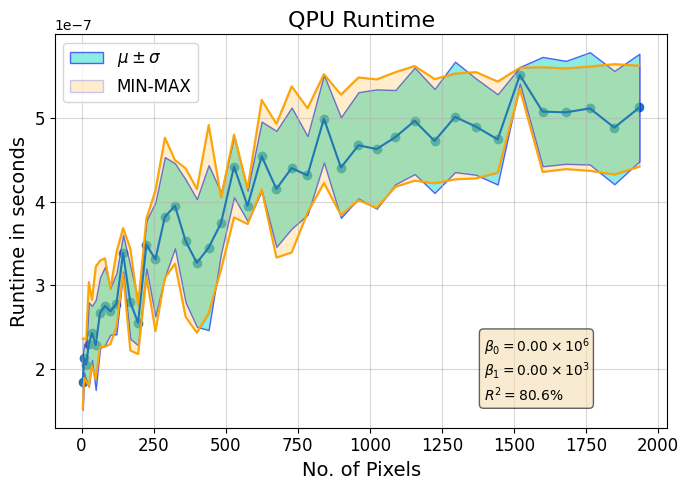

In [ ]:
column = "qpu_access_time"
plot_and_save(times_df, column, 10**6)

43
b0 =  [-1.0461227]
b1 =  0.03713223930301758


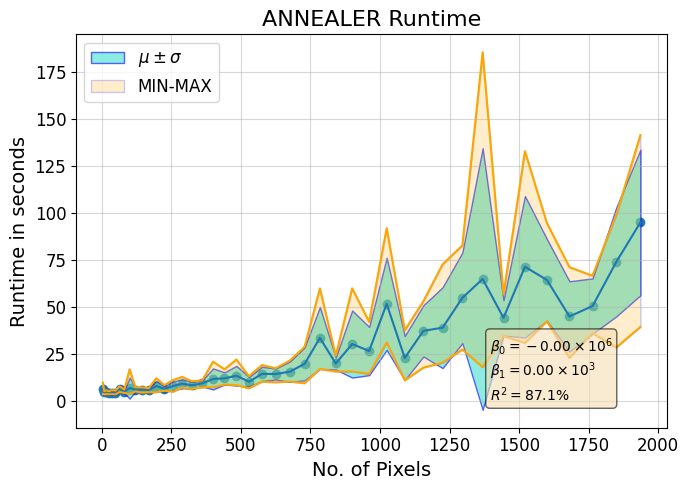

In [ ]:
column = "annealer_tte"
plot_and_save(times_df, column)

43
b0 =  [-16.12796067]
b1 =  0.07949239092316018


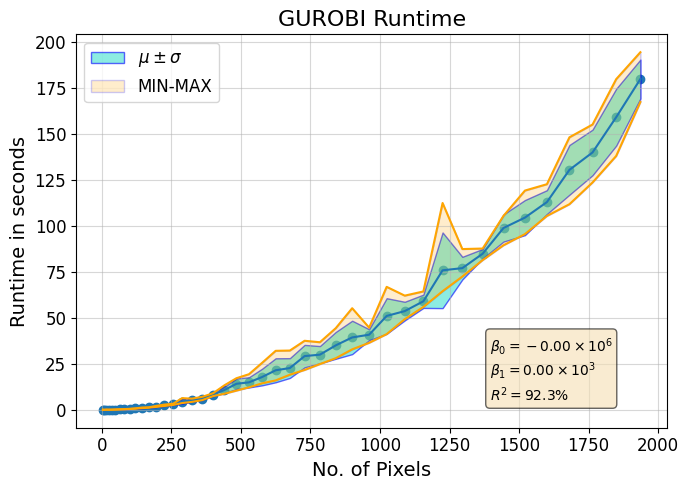

In [ ]:
column = "gurobi_tte"
plot_and_save(times_df, column)